In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Korn64bit/data_sender_api/refs/heads/main/flask/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
df_renamed = df.rename(columns={'Product ID': 'product_id',
                                'Type': 'type',
                                'Air temperature [K]': 'air_temp_k', 
                                'Process temperature [K]': 'process_temp_k',
                                'Rotational speed [rpm]': 'rotational_speed_rpm',
                                'Torque [Nm]': 'torque_nm',
                                'Tool wear [min]': 'tool_wear_min',
                                'Machine failure': 'machine_failure'})
df_renamed.head()

,UDI,product_id,type,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
df_renamed.to_csv('ai4i_renamed.csv')

In [14]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

encoded_column = 'type'
df_rdy = df_renamed.copy()
df_rdy[encoded_column + '_encoded'] = labelencoder.fit_transform(df_renamed[encoded_column]).copy()
display(df_rdy.head())
mapping = {original_val: encoded_val for encoded_val, original_val in enumerate(labelencoder.classes_)}
for original, encoded in mapping.items():
    print(f'{original} -> {encoded}')

,UDI,product_id,type,air_temp_k,process_temp_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,TWF,HDF,PWF,OSF,RNF,type_encoded
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,2
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,1
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,1
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,1
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,1


H -> 0
L -> 1
M -> 2


In [36]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_rdy[['type_encoded', 'air_temp_k', 'process_temp_k', 'rotational_speed_rpm', 'torque_nm', 'tool_wear_min']]
y = df_rdy['machine_failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(k_neighbors=5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote.shape, y_train_smote.shape


((15444, 6), (15444,))

In [55]:
from imblearn.combine import SMOTETomek, SMOTEENN

# SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train, y_train)
print("SMOTE + Tomek Links:", X_train_smote_tomek.shape, y_train_smote_tomek.shape)

# SMOTE + ENN
smote_enn = SMOTEENN(random_state=42)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)
print("SMOTE + ENN:", X_train_smote_enn.shape, y_train_smote_enn.shape)

SMOTE + Tomek Links: (15286, 6) (15286,)
SMOTE + ENN: (13911, 6) (13911,)


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

param_grid_logreg = [
    {
        'logreg__solver': ['liblinear'], # liblinear is good for small datasets and supports l1/l2
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__max_iter': [100, 200] # liblinear usually converges fast
    },
    {
        'logreg__solver': ['lbfgs', 'newton-cg', 'sag'], # These support 'l2' or no penalty
        'logreg__penalty': ['l2', None], # Or 'none' if using older scikit-learn
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__max_iter': [100, 200, 500] # sag might need more iterations
    },
    {
        'logreg__solver': ['saga'], # saga is versatile
        'logreg__penalty': ['elasticnet', 'l1', 'l2', None],
        'logreg__C': [0.01, 0.1, 1, 10, 100],
        'logreg__l1_ratio': np.linspace(0.1, 0.9, 5).tolist(), # Only for elasticnet, avoid 0 and 1 if also testing l1/l2 separately
        'logreg__max_iter': [100, 200, 500, 1000] # saga might need more iterations
    }
]

grid_search_logreg = GridSearchCV(estimator=pipeline,
                                  param_grid=param_grid_logreg,
                                  cv=5,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  verbose=1)
grid_search_logreg.fit(X_train_smote, y_train_smote)
best_logreg_pipeline = grid_search_logreg.best_estimator_
print("\nBest parameters found for Logistic Regression:")
print(grid_search_logreg.best_params_)
print(f"Best accuracy score: {grid_search_logreg.best_score_:.4f}")

Fitting 5 folds for each of 510 candidates, totalling 2550 fits

Best parameters found for Logistic Regression:
{'logreg__C': 0.1, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best accuracy score: 0.8335


In [38]:
from sklearn.metrics import classification_report

best_logreg_pipeline.fit(X_train_smote, y_train_smote)
y_pred = best_logreg_pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1939
           1       0.14      0.84      0.24        61

    accuracy                           0.84      2000
   macro avg       0.57      0.84      0.57      2000
weighted avg       0.97      0.84      0.89      2000



In [45]:
import joblib

joblib.dump(best_logreg_pipeline, 'model/logreg_model.pkl')

['model/logreg_model.pkl']

In [42]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rfc = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier(random_state=42)
grid_search_rfc = GridSearchCV(estimator=rfc, 
                               param_grid=param_grid_rfc,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)
grid_search_rfc.fit(X_train_smote, y_train_smote)
best_rfc = grid_search_rfc.best_estimator_
print("\nBest parameters found for Random Forest Classifier:")
print(grid_search_rfc.best_params_)
print(f"Best accuracy score: {grid_search_rfc.best_score_:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters found for Random Forest Classifier:
{'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best accuracy score: 0.9808


In [44]:
from sklearn.metrics import classification_report

best_rfc.fit(X_train_smote, y_train_smote)
y_pred = best_rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1939
           1       0.46      0.72      0.56        61

    accuracy                           0.97      2000
   macro avg       0.72      0.85      0.77      2000
weighted avg       0.97      0.97      0.97      2000



In [46]:
import joblib

joblib.dump(best_rfc, 'model/rfc_model.pkl')

['model/rfc_model.pkl']

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.01, 0.1],
    # 'reg_lambda': [0.1, 1]
}


xgbc = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgbc, 
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)
grid_search_xgb.fit(X_train_smote, y_train_smote)
best_xgb = grid_search_xgb.best_estimator_
print("\nBest parameters found for XGBoost Classifier:")
print(grid_search_xgb.best_params_)
print(f"Best accuracy score: {grid_search_xgb.best_score_:.4f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters found for XGBoost Classifier:
{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
Best accuracy score: 0.9848


In [53]:
from sklearn.metrics import classification_report

best_xgb.fit(X_train_smote, y_train_smote)
y_pred = best_xgb.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1939
           1       0.46      0.72      0.56        61

    accuracy                           0.97      2000
   macro avg       0.72      0.85      0.77      2000
weighted avg       0.97      0.97      0.97      2000



In [54]:
import joblib

joblib.dump(best_xgb, 'model/xgbclassifier.pkl')

['model/xgbclassifier.pkl']

In [62]:
import xgboost as xgb
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0, 0.1, 0.2],
}


xgbc = XGBClassifier(random_state=42)
grid_search_xgb_2 = GridSearchCV(estimator=xgbc, 
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)
grid_search_xgb_2.fit(X_train_smote_tomek, y_train_smote_tomek)
best_xgb_2 = grid_search_xgb_2.best_estimator_
print("\nBest parameters found for XGBoost Classifier:")
print(grid_search_xgb_2.best_params_)
print(f"Best accuracy score: {grid_search_xgb_2.best_score_:.4f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters found for XGBoost Classifier:
{'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
Best accuracy score: 0.9866


In [63]:
from sklearn.metrics import classification_report

best_xgb_2.fit(X_train_smote, y_train_smote)
y_pred = best_xgb_2.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1939
           1       0.46      0.74      0.57        61

    accuracy                           0.97      2000
   macro avg       0.73      0.86      0.77      2000
weighted avg       0.98      0.97      0.97      2000



In [64]:
import xgboost as xgb
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_child_weight': [1, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0, 0.1, 0.2],
}


xgbc = XGBClassifier(random_state=42)
grid_search_xgb_3 = GridSearchCV(estimator=xgbc, 
                               param_grid=param_grid_xgb,
                               cv=5,
                               scoring='accuracy',
                               n_jobs=-1,
                               verbose=1)
grid_search_xgb_3.fit(X_train_smote_enn, y_train_smote_enn)
best_xgb_3 = grid_search_xgb_3.best_estimator_
print("\nBest parameters found for XGBoost Classifier:")
print(grid_search_xgb_3.best_params_)
print(f"Best accuracy score: {grid_search_xgb_3.best_score_:.4f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best parameters found for XGBoost Classifier:
{'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.9}
Best accuracy score: 0.9921


In [65]:
from sklearn.metrics import classification_report

best_xgb_3.fit(X_train_smote, y_train_smote)
y_pred = best_xgb_3.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1939
           1       0.48      0.77      0.59        61

    accuracy                           0.97      2000
   macro avg       0.74      0.87      0.79      2000
weighted avg       0.98      0.97      0.97      2000



In [66]:
import joblib

joblib.dump(best_xgb_3, 'model/xgbclassifier.pkl')

['model/xgbclassifier.pkl']

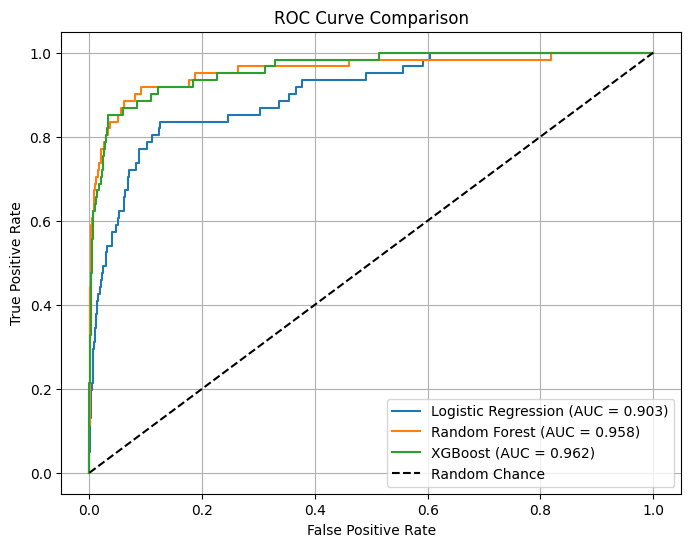

In [70]:
from sklearn.metrics import roc_curve, roc_auc_score

# Logistic Regression
y_proba_logreg = best_logreg_pipeline.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)
auc_logreg = roc_auc_score(y_test, y_proba_logreg)

# Random Forest
y_proba_rfc = best_rfc.predict_proba(X_test)[:, 1]
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, y_proba_rfc)
auc_rfc = roc_auc_score(y_test, y_proba_rfc)

# XGBoost (already computed as fpr, tpr, auc_score)
# fpr, tpr, auc_score

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.3f})')
plt.plot(fpr_rfc, tpr_rfc, label=f'Random Forest (AUC = {auc_rfc:.3f})')
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()